# Example of DUKF<sup>1</sup>  and DAUKF<sup>2</sup>

[1] Dual Unscented Kalman Filter

[2] Dual Adaptive Unscented Kalman Filter

----

Author        :   Seongchun Yang

Affiliation   :   Kyoto University

In [1]:
import numpy as np
import scipy
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from itertools import product
import sys; sys.path.append('./')

np.random.seed(1)

## Simulate Data

-----

- State Transition
    - $ z_{t,1} = z_{t-1,1} + p_{t,1} \times m_t + \epsilon_z $
    - $ z_{t,2} = z_{t-1,2} + p_{t,2} \times m_t + \epsilon_z $
- Observation
    - $ y_{t,1} = z_{t,1} \times z_{t,2} + \epsilon_y $
    - $ y_{t,2} = z_{t,2} + \epsilon_y $
- Annotation
    - $z_{t,1}$ : first state at time point t
    - $p_{t,1}$ : first parameter at time point t
    - $y_{t,1}$ : first observation at time point t
    - $m_t$ : filter input at time t
    - $\epsilon_z$ : state filter transition noise, $Var(\epsilon_z) = Q$
    - $\epsilon_y$ : state filter measurement noise, $Var(\epsilon_y) = R$


Assume such a case where we only have observations of $y_1$, $z_2$, and the input values of $m$. <br>
We want to know the state values without the parameter and input influence, and also estimate what those parameters are.

There are certainly many other ways of factorizing such a data. <br>
But for those of us who require a full Bayesian treatment and if the data just so happen to work with Markov property, Kalman filters and its relatives are a great match.

In this notebook, we compare two cases of utilizing Unscented Kalman filter (UKF), a dual version (DUKF) and a measurement-noise adaptive dual version (DAUKF). <br>

In [2]:
n = 100 # number of samples
noise_var = 0.5 # sensor noise setting by variance

def state_generator(z0,ps,ms):
    '''
    Simulates the state values as in the state-transition described in markdown above
    Parameters
    ----------
    z0  :   float
        initial start of the state
    ps  :   array_like
        1D, initialized parameter input
    ms  :   array_like
        1D, initialized manual input
    Returns
    -------
    zs  :   np.ndarray
        simulated state
    '''
    zs = [z0]
    for p,m in zip(ps,ms):
        zs.append(zs[-1] + p * m)
    return np.array(zs[1:])
        
# parameter
p1 = np.sin(np.linspace(0,10*np.pi,n)) # parameter1
p2 = np.cos(np.linspace(0,10*np.pi,n)) # parameter2
ms = np.array([1 if random.random() < 0.5 else -1 for i in range(n)]) # inputs (randomly between 1 and -1)
# state
x1 = state_generator(1,p1,ms)
x2 = state_generator(1,p2,ms)
# observation 1 - uncorrelated independent noise added as simulating sensor noise
y1 = np.multiply(x1,x2)
y1_noisy = np.array([np.random.normal(i,np.sqrt(noise_var),1) for i in y1])
# observation 2 - uncorrelated independent noise added as simulating sensor noise
y2 = np.copy(x2)
y2_noisy = np.array([np.random.normal(i,np.sqrt(noise_var),1) for i in y2])
# package data
obs_noisy = np.array([y1_noisy.flatten(),y2_noisy.flatten()]).T

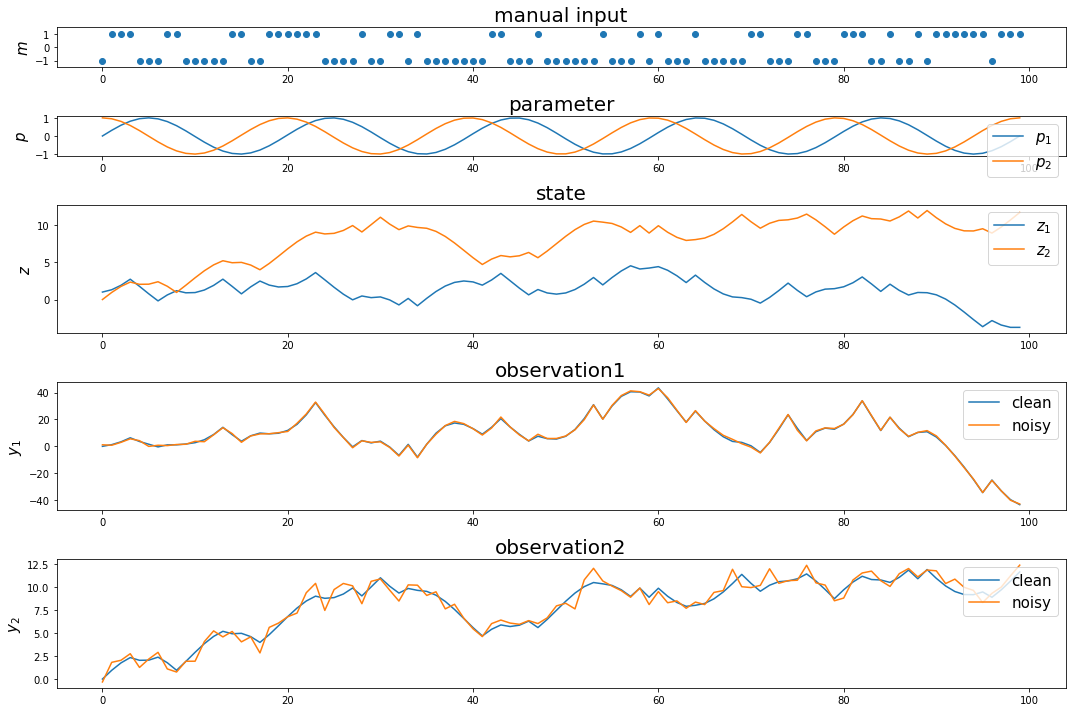

In [3]:
# plot
fig=plt.figure(figsize=(15,10))
grid=gridspec.GridSpec(nrows=8,ncols=1,figure=fig)

ax1=fig.add_subplot(grid[0,0])
ax1.scatter(list(range(n)),ms)
ax1.set_ylim(-1.5,1.5)
ax1.set_title('manual input',size=20)
ax1.set_ylabel(r'$m$',size=15)

ax2=fig.add_subplot(grid[1,0])
ax2.plot(p1,label=r'$p_1$')
ax2.plot(p2,label=r'$p_2$')
ax2.set_title('parameter',size=20)
ax2.set_ylabel(r'$p$',size=15)
ax2.legend(loc = 'upper right', fontsize=15)

ax3=fig.add_subplot(grid[2:4,0])
ax3.plot(x1,label=r'$z_1$')
ax3.plot(x2,label=r'$z_2$')
ax3.set_title('state',size=20)
ax3.set_ylabel(r'$z$',size=15)
ax3.legend(loc='upper right',fontsize=15)

ax4=fig.add_subplot(grid[4:6,0])
ax4.plot(y1,label='clean')
ax4.plot(y1_noisy,label='noisy')
ax4.set_title('observation1',size=20)
ax4.set_ylabel(r'$y_1$',size=15)
ax4.legend(loc = 'upper right',fontsize=15)

ax5=fig.add_subplot(grid[6:8,0])
ax5.plot(y2,label='clean')
ax5.plot(y2_noisy,label='noisy')
ax5.set_title('observation2',size=20)
ax5.set_ylabel(r'$y_2$',size=15)
ax5.legend(loc = 'upper right',fontsize=15)
fig.tight_layout()

# DUKF

------

Dual mode of not only UKF but EKF and KF have certain advantages over joint mode. <br>
This mostly has to do with how dual mode handles transition, i.e., functionally zero cross-covariance.

> Should one of your state or parameter be changing on a different time scale over another, dual mode offers better clarity over joint mode. To be more specific, joint mode over highly correleated variables may produce a state estimate that is lagging in time.

<br>

> It can be more intuitive. With time-series data, keeping all variables inline with its Markov assumption while estimating them all simulataneously can be arduous. Dual mode also preserves the initial value of the state without converting it to an observation value (e.g., $y_t = z_t \times p_t$, $z_t = z_{t-1}$).

Here, the dual mode is implemented such that the previous time estimate of one filter is used in the current time trial of the other filter and vice versa.

In [4]:
from KF.DUKF import DualUKF
from filterpy.kalman import MerweScaledSigmaPoints

In [5]:
# initialize object
def s_fx(x,**kwargs):
    p1 = kwargs['past_p'][0]
    p2 = kwargs['past_p'][1]
    m = kwargs['m']
    x1 = x[0] + p1 * m
    x2 = x[1] + p2 * m
    return [float(x1),float(x2)]

def s_hx(x,**kwargs):
    y1 = x[0] * x[1]
    y2 = x[1]
    return [float(y1),float(y2)]

def p_fx(x,**kwargs):
    return x

def p_hx(x,**kwargs):
    p1 = x[0]
    p2 = x[1]
    m = kwargs['m']
    x1 = kwargs['past_z'][0]
    x2 = kwargs['past_z'][1]
    x1 = x1 + p1 * m
    x2 = x2 + p2 * m
    return [float(x1),float(x2)]

DUKF = DualUKF(
    n           =   n,
    s_dim_z     =   2,
    s_dim_x     =   2,
    s_z0        =   np.array([x1[0],x2[0]]),
    s_P0        =   np.eye(2),
    s_Q         =   np.eye(2),
    s_R         =   np.eye(2),
    s_fx        =   s_fx,
    s_hx        =   s_hx,
    s_points_fn =   MerweScaledSigmaPoints(
        n = 2,
        kappa = 1,
        alpha = 0.001,
        beta = 2
    ),
    p_dim_z     =   2,
    p_dim_x     =   2,
    p_z0        =   np.array([p1[0],p2[0]]),
    p_P0        =   np.eye(2),
    p_Q         =   np.eye(2),
    p_R         =   np.eye(2),
    p_fx        =   p_fx,
    p_hx        =   p_hx,
    p_points_fn =   MerweScaledSigmaPoints(
        n = 2,
        kappa = 1,
        alpha = 0.001,
        beta = 2
    )
)
## run DUKF
DUKF.reparameterization(obs_noisy[0,:],ms[0])
DUKF.main(obs_noisy,ms.reshape(-1,1))

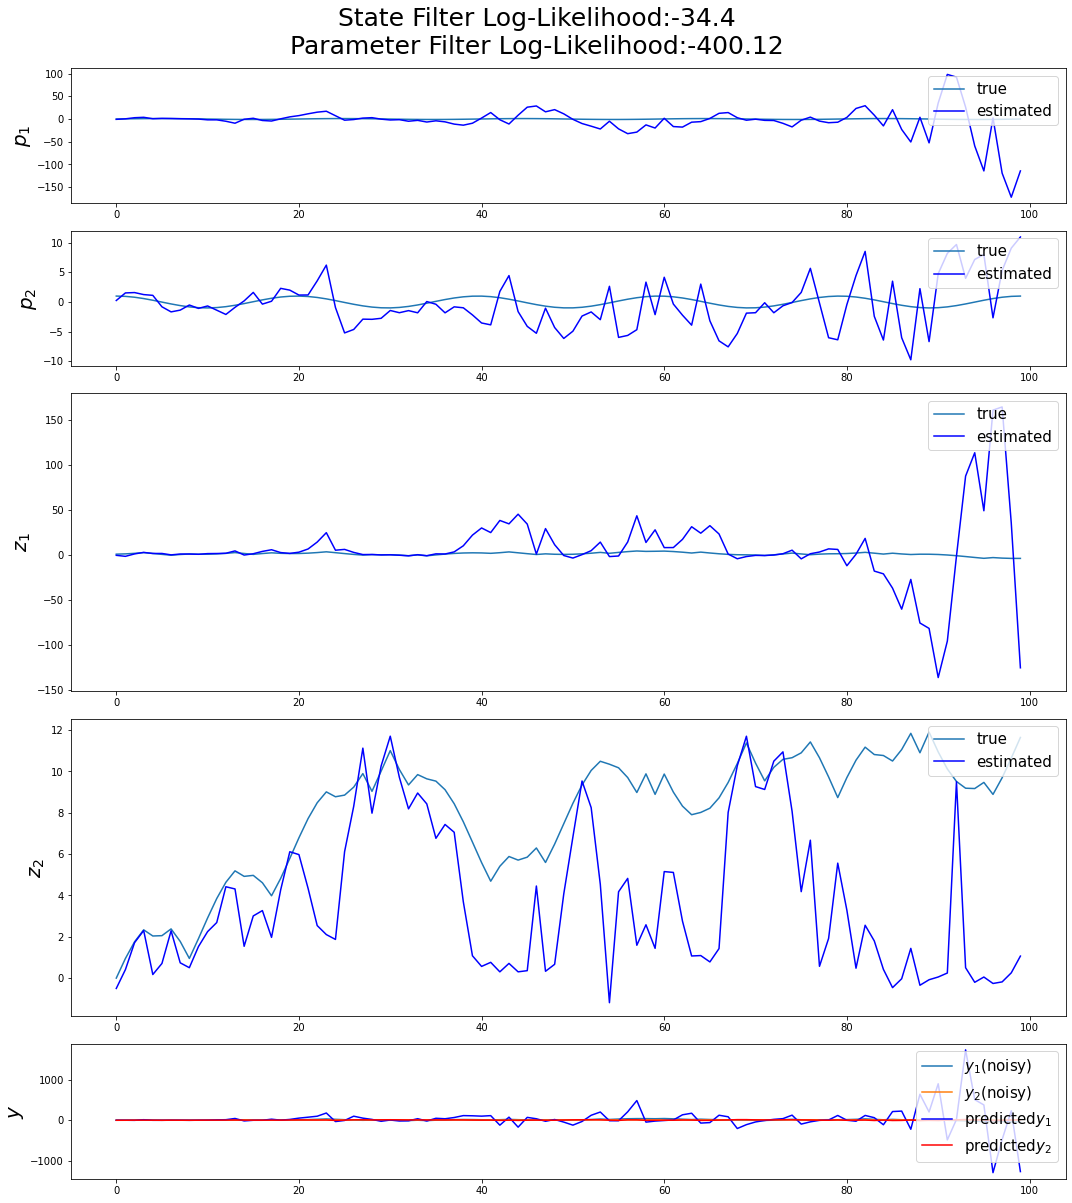

In [6]:
fig=plt.figure(figsize=(15,17))
grid=gridspec.GridSpec(nrows=7,ncols=1,figure=fig)
fig.suptitle(
    'State Filter Log-Likelihood:{}\n'.format(
        np.round(
            np.mean(DUKF.sUKF.log_likelihoods),
            2)
    ) + 
    'Parameter Filter Log-Likelihood:{}'.format(
        np.round(
            np.mean(DUKF.pUKF.log_likelihoods),
            2)
    )
    ,
    size=25
)
# estimated parameter1
ax1=fig.add_subplot(grid[0,0])
ax1.plot(p1,label='true')
ax1.plot(DUKF.pUKF.zs[:,0],label='estimated',color='b')
ax1.set_ylabel(r'$p_1$',fontsize=20,weight='bold')
ax1.legend(loc='upper right',fontsize=15)
# estimated parameter2
ax2=fig.add_subplot(grid[1,0])
ax2.plot(p2,label='true')
ax2.plot(DUKF.pUKF.zs[:,1],label='estimated',color='b')
ax2.set_ylabel(r'$p_2$',fontsize=20,weight='bold')
ax2.legend(loc='upper right',fontsize=15)
# estimated z1
ax3=fig.add_subplot(grid[2:4,0])
ax3.plot(x1,label='true')
ax3.plot(DUKF.sUKF.zs[:,0],label='estimated',color='b')
ax3.set_ylabel(r'$z_1$',size=20,weight='bold')
ax3.legend(loc='upper right',fontsize=15)
# filtered x2
ax4=fig.add_subplot(grid[4:6,0])
ax4.plot(x2,label='true')
ax4.plot(DUKF.sUKF.zs[:,1],label='estimated',color='b')
ax4.set_ylabel(r'$z_2$',size=20,weight='bold')
ax4.legend(loc='upper right',fontsize=15)
# observation predictions
ax5=fig.add_subplot(grid[6:8,0])
ax5.plot(y1_noisy,label=r'$y_1$'+'(noisy)')
ax5.plot(y2_noisy,label=r'$y_2$'+'(noisy)')
ax5.plot(DUKF.sUKF.xps[:,0],label='predicted'+r'$y_1$',color='b')
ax5.plot(DUKF.sUKF.xps[:,1],label='predicted'+r'$y_2$',color='r')
ax5.set_ylabel(r'$y$',size=20,weight='bold')
ax5.legend(loc='upper right',fontsize=15)

fig.tight_layout()
fig.subplots_adjust(top=0.93)

This didnt' seem to work very well. The filter can be seen diverging away at time 60 or so, and this is especially apparent when you look at the parameter filter log likelihood.

## DAUKF

-----


DAUKF to the rescue! Kalman filters can be finicky; depending on the initial conditions and noise variances used for transition ($Q$) or measurement ($R$), the filter can diverge away to infinity<sup>3</sup>.

Then we can do certain things to make the filter more flexible and adaptive to the data at hand. We already have implemented one for initialization via function *reparameterization*, built right into both DUKF and DAUKF. This will allow the filter to adjust once the initial guesses are put in such that the filter gets its best chance at life.

For transition and measurement noise, it's tricky. Larger transition noise will make the filter sensitive to changes in value, at the cost of incorporating noise (fluctuations to the estimation). Larger measurement noise will allow the filter to stay within the vicinity, but too large the filter will diverge away.

<br>

A different approach is to make either of the noise variances fluctuate in time. A popular approach is in adaptive measurement noise, which may be applicable to sensor noises that change in time are uncertain from the beginning. For changing sensor noise, DAUKF will ensure its R also changes in time as well. For an uncertain value of $R$, DAUKF will slowly adjust to a value required for the filter such that it does not diverge.

The implementation seen here adapts $R$ for both filters. They can be accessed with the following syntax;

- *DAUKF.sAUKF.Rs*
- *DAUKF.pAUKF.Rs*


[3] Literally, the log-likelihood will show negative infinite value.

In [7]:
from KF.DAUKF import DualAdaptiveUKF

In [8]:
DAUKF = DualAdaptiveUKF(
    n           =   n,
    delta       =   0.7,
    s_dim_z     =   2,
    s_dim_x     =   2,
    s_z0        =   np.array([x1[0],x2[0]]),
    s_P0        =   np.eye(2),
    s_Q         =   np.eye(2),
    s_R         =   np.eye(2),
    s_fx        =   s_fx,
    s_hx        =   s_hx,
    s_points_fn =   MerweScaledSigmaPoints(
        n = 2,
        kappa = 1,
        alpha = 0.001,
        beta = 2
    ),
    p_dim_z     =   2,
    p_dim_x     =   2,
    p_z0        =   np.array([p1[0],p2[0]]),
    p_P0        =   np.eye(2),
    p_Q         =   np.eye(2),
    p_R         =   np.eye(2),
    p_fx        =   p_fx,
    p_hx        =   p_hx,
    p_points_fn =   MerweScaledSigmaPoints(
        n = 2,
        kappa = 1,
        alpha = 0.001,
        beta = 2
    )
)
## run DUKF
DAUKF.reparameterization(obs_noisy[0,:],ms[0])
DAUKF.main(obs_noisy,ms.reshape(-1,1))

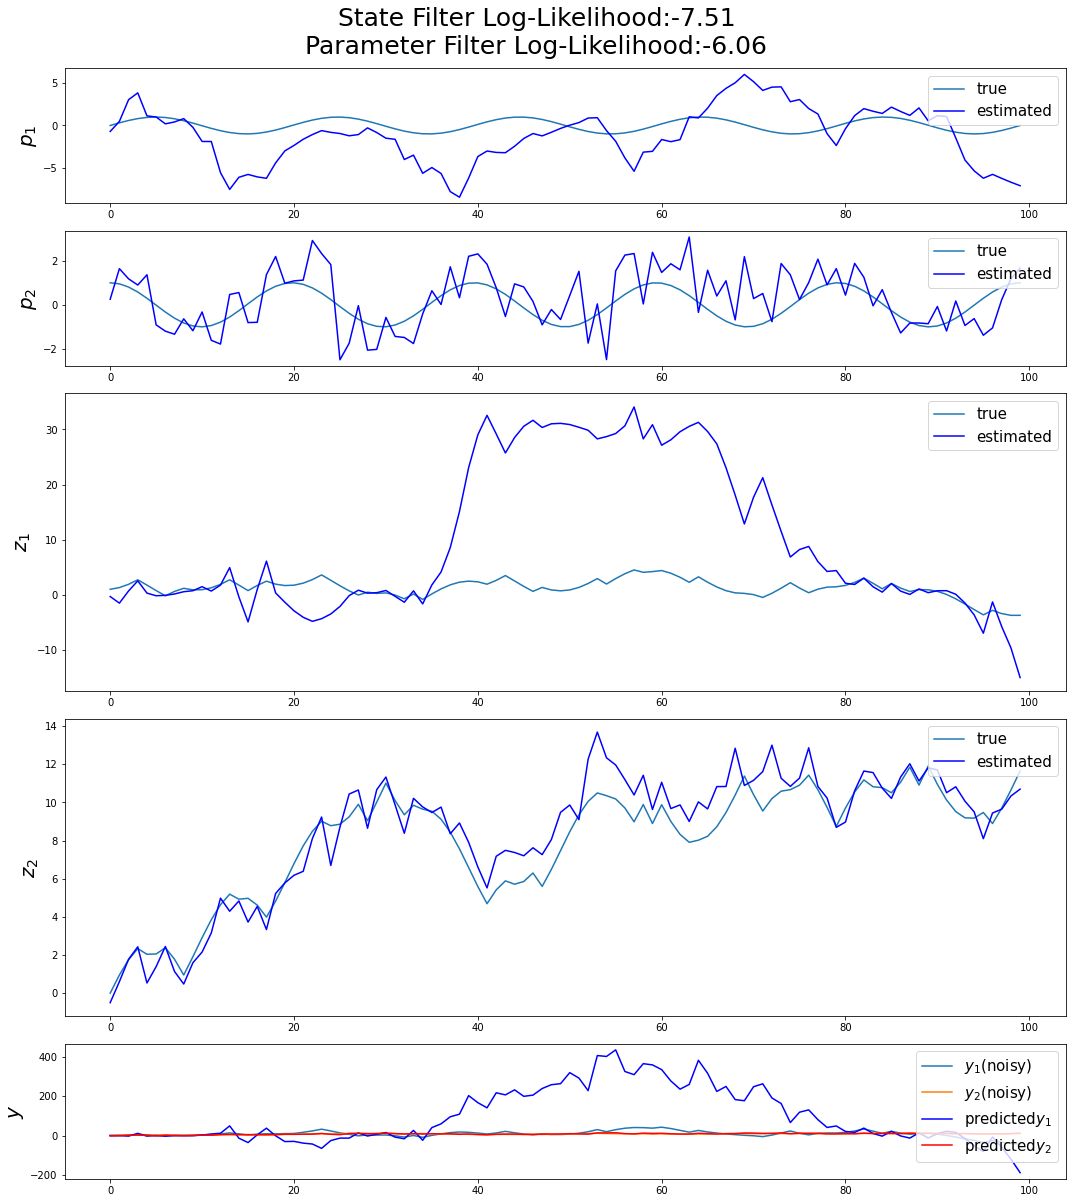

In [9]:
fig=plt.figure(figsize=(15,17))
grid=gridspec.GridSpec(nrows=7,ncols=1,figure=fig)
fig.suptitle(
    'State Filter Log-Likelihood:{}\n'.format(
        np.round(
            np.mean(DAUKF.sAUKF.log_likelihoods),
            2)
    ) + 
    'Parameter Filter Log-Likelihood:{}'.format(
        np.round(
            np.mean(DAUKF.pAUKF.log_likelihoods),
            2)
    )
    ,
    size=25
)
# estimated parameter1
ax1=fig.add_subplot(grid[0,0])
ax1.plot(p1,label='true')
ax1.plot(DAUKF.pAUKF.zs[:,0],label='estimated',color='b')
ax1.set_ylabel(r'$p_1$',fontsize=20,weight='bold')
ax1.legend(loc='upper right',fontsize=15)
# estimated parameter2
ax2=fig.add_subplot(grid[1,0])
ax2.plot(p2,label='true')
ax2.plot(DAUKF.pAUKF.zs[:,1],label='estimated',color='b')
ax2.set_ylabel(r'$p_2$',fontsize=20,weight='bold')
ax2.legend(loc='upper right',fontsize=15)
# estimated z1
ax3=fig.add_subplot(grid[2:4,0])
ax3.plot(x1,label='true')
ax3.plot(DAUKF.sAUKF.zs[:,0],label='estimated',color='b')
ax3.set_ylabel(r'$z_1$',size=20,weight='bold')
ax3.legend(loc='upper right',fontsize=15)
# filtered x2
ax4=fig.add_subplot(grid[4:6,0])
ax4.plot(x2,label='true')
ax4.plot(DAUKF.sAUKF.zs[:,1],label='estimated',color='b')
ax4.set_ylabel(r'$z_2$',size=20,weight='bold')
ax4.legend(loc='upper right',fontsize=15)
# observation predictions
ax5=fig.add_subplot(grid[6:8,0])
ax5.plot(y1_noisy,label=r'$y_1$'+'(noisy)')
ax5.plot(y2_noisy,label=r'$y_2$'+'(noisy)')
ax5.plot(DAUKF.sAUKF.xps[:,0],label='predicted'+r'$y_1$',color='b')
ax5.plot(DAUKF.sAUKF.xps[:,1],label='predicted'+r'$y_2$',color='r')
ax5.set_ylabel(r'$y$',size=20,weight='bold')
ax5.legend(loc='upper right',fontsize=15)

fig.tight_layout()
fig.subplots_adjust(top=0.93)

As you can see, it isn't perfect. Now that I think of it, the data itself isn't that great. But the point is, we have successfully gauged the values of state and parameters.

Note that there were no assumptions made about the state transition of parameters (we just let them pass from the past state to the current state as is with added noise). A more detailed domain knowledge will dramatically increase the effect of UKF and its relatives.

Let's see at least if the signal looks anyting like the origina parameter signal.

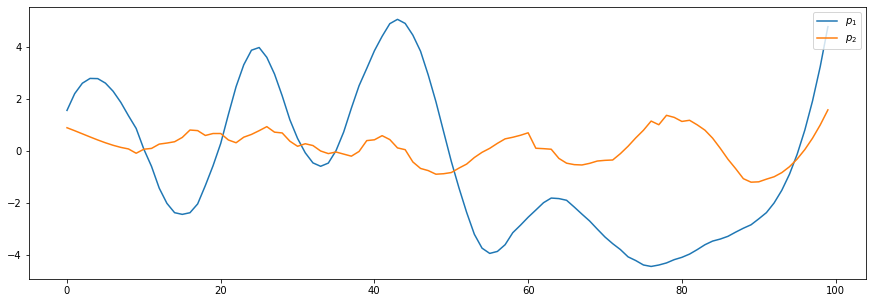

In [ ]:
from scipy.signal import savgol_filter

fig=plt.figure(figsize=(15,5))
plt.plot(savgol_filter(DAUKF.pAUKF.zs[:,0],17,3),label=r'$p_1$')
plt.plot(savgol_filter(DAUKF.pAUKF.zs[:,1],17,3),label=r'$p_2$')
plt.legend(loc='upper right')

Not to shabby eh?